In [1]:
!git clone https://github.com/marius-sm/sign_language_translation
!pip install transformers --upgrade
!pip uninstall tokenizers -y

Cloning into 'sign_language_translation'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 550 (delta 89), reused 113 (delta 50), pack-reused 396
Receiving objects: 100% (550/550), 1.65 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (322/322), done.
     |████████████████████████████████| 1.8 MB 3.0 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.0.1
    Uninstalling transformers-4.0.1:
      Successfully uninstalled transformers-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.3.0 requires transformers<4.1,>=4.0, but you have transformers 4.2.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Found existing ins

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import math
import os
import time
import PIL
import glob
import pickle
import numpy as np
from tqdm import tqdm
from IPython import display
import transformers

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
def get_path_pairs(subset='train'):
    mask_paths = glob.glob(f'/kaggle/input/cityscapes/Cityspaces/gtFine/{subset}/*/*gtFine_labelIds.png')
    image_paths = []
    for mask_path in mask_paths:
        image_path = mask_path.replace('/gtFine/', '/images/').replace('gtFine_labelIds', 'leftImg8bit')
        image_paths.append(image_path)
        
    return list(zip(image_paths, mask_paths))

train_path_pairs = get_path_pairs('train')
val_path_pairs = get_path_pairs('val')

short_image_side = 224

In [25]:
val_samples = []
for image_path, mask_path in tqdm(val_path_pairs):
    image = PIL.Image.open(image_path).resize(((short_image_side+short_image_side//10), short_image_side+short_image_side//10), resample=PIL.Image.BILINEAR)
    mask = PIL.Image.open(mask_path).resize(((short_image_side+short_image_side//10), short_image_side+short_image_side//10), resample=PIL.Image.NEAREST)
    val_samples.append((image, mask))

100%|██████████| 500/500 [00:52<00:00,  9.46it/s]


In [5]:
train_samples = []
for image_path, mask_path in tqdm(train_path_pairs):
    image = PIL.Image.open(image_path).resize((2*(short_image_side+short_image_side//10), short_image_side+short_image_side//10), resample=PIL.Image.BILINEAR)
    mask = PIL.Image.open(mask_path).resize((2*(short_image_side+short_image_side//10), short_image_side+short_image_side//10), resample=PIL.Image.NEAREST)
    train_samples.append((image, mask))

100%|██████████| 2975/2975 [07:27<00:00,  6.65it/s]


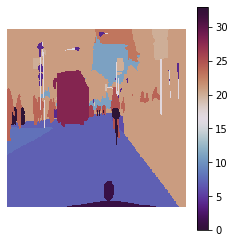

In [26]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None, image_transform=None, mask_transform=None, return_what=['image, mask'], deterministic=False):
        super(SegmentationDataset, self).__init__()
        self.samples = samples
        self.transform = transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.deterministic = True
        
        if not isinstance(return_what, list): return_what = [return_what]
        self.return_what = return_what
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        
        image, mask = self.samples[idx][:2]
        
        if self.deterministic:
            image = torchvision.transforms.functional.center_crop(image, output_size=(short_image_side, short_image_side))
            mask = torchvision.transforms.functional.center_crop(mask, output_size=(short_image_side, short_image_side))
        else:
            i, j, h, w = torchvision.transforms.RandomCrop.get_params(image, output_size=(short_image_side, short_image_side))
        
            if 'image' in self.return_what:
                image = image.crop((j, i, j+w, i+h))
            if 'mask' in self.return_what:
                mask = mask.crop((j, i, j+w, i+h))
        
        if self.transform is not None:
            if 'image' in self.return_what:
                image = self.transform(image)
            if 'mask' in self.return_what:
                mask = self.transform(mask)
        if self.image_transform is not None and 'image' in self.return_what:
            image = self.image_transform(image)
        if self.mask_transform is not None and 'mask' in self.return_what:
            mask = self.mask_transform(mask)
        
        if 'mask' in self.return_what:
            mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        
        returns = []
        for s in self.return_what:
            if s == 'mask':
                returns.append(mask)
            if s == 'image':
                returns.append(image)
        if len(returns) == 1:
            return returns[0]
        return returns
    
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset = SegmentationDataset(val_samples, image_transform=image_transform, return_what=['image', 'mask'])
valid_dataset = SegmentationDataset(val_samples, image_transform=image_transform, return_what=['image', 'mask'], deterministic=True)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=24, drop_last=True, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=24, drop_last=False, shuffle=False, num_workers=0)
batch = next(iter(validloader))

plt.matshow(train_dataset[3][1], cmap='twilight_shifted', vmin=0, vmax=33)
plt.axis('off')
plt.colorbar();

In [17]:
def training_step_fn(model, batch):
    images, masks = batch
    images = images.to(device)
    masks = masks.to(device)
    logits = model(images)
    loss = F.cross_entropy(logits, masks, reduction='none').mean((-1, -2, -3))
    summed_loss = loss.sum()
    num_samples = images.shape[0]
    num_correct_samples = (logits.argmax(1) == masks).float().mean((-1, -2)).sum()
    return num_samples, num_correct_samples, summed_loss

In [18]:
def test_model(model, image, target_mask, save_pred=None, save_target=None):
    model.eval()
    with torch.no_grad():
        pred_mask = model(image.unsqueeze(0).to(device))[0].cpu()
        pred_mask = pred_mask.argmax(0)
    
    plt.matshow(pred_mask, cmap='twilight_shifted', vmin=0, vmax=33)
    plt.axis('off')
    if isinstance(save_pred, str):
        plt.savefig(save_pred, bbox_inches='tight')
    plt.show()
    plt.matshow(target_mask, cmap='twilight_shifted', vmin=0, vmax=33)
    plt.axis('off')
    if isinstance(save_target, str):
        plt.savefig(save_target, bbox_inches='tight')
    plt.show()

In [19]:
def set_lr(model, lr):
    for pg in model.optimizer.param_groups:
        pg['lr'] = lr

In [20]:
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

# U-Net

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, num_classes, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
    
unet = UNet(num_classes=34)
unet.optimizer = torch.optim.Adam(unet.parameters(), 1e-3)
unet.to(device);

In [5]:
count_params(unet)

7785058

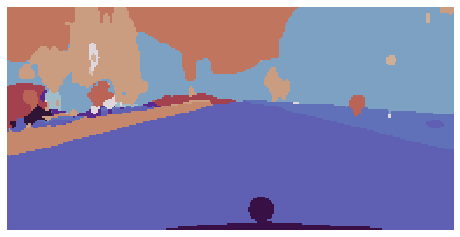

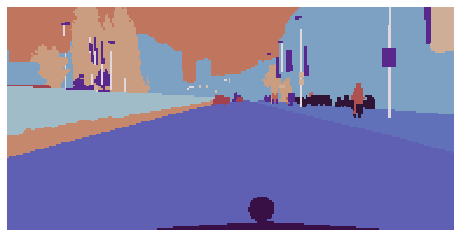

In [58]:
image, target_mask = valid_dataset[6]
test_model(unet, image, target_mask, save_pred='unet_6.png', save_target='target_6.png')

In [27]:
def on_epoch_end(logs):
    if logs['epoch'] == 10:
        set_lr(unet, 5e-4)
    if logs['epoch'] == 20:
        set_lr(unet, 1e-4)

unet_training_data = train_model(
    model=unet,
    training_step_fn=training_step_fn, 
    trainloader=trainloader,
    validloader=validloader,
    print_every=10,
    epochs=30,
    on_epoch_end=on_epoch_end
)

with open('unet_training_data.pickle', 'wb') as handle:
    pickle.dump(unet_training_data, handle)

Epoch 0, iteration 10/123: running loss 0.1450, running acc 0.1293, batch loss: 0.1422, batch acc: 0.2199, running time per batch: 0.3243s (model) 0.0273s (loader)
Epoch 0, iteration 20/123: running loss 0.1360, running acc 0.1811, batch loss: 0.1233, batch acc: 0.2464, running time per batch: 0.3197s (model) 0.0231s (loader)
Epoch 0, iteration 30/123: running loss 0.1139, running acc 0.2097, batch loss: 0.0879, batch acc: 0.3740, running time per batch: 0.3180s (model) 0.0210s (loader)
Epoch 0, iteration 40/123: running loss 0.0963, running acc 0.3087, batch loss: 0.0862, batch acc: 0.3531, running time per batch: 0.3174s (model) 0.0202s (loader)
Epoch 0, iteration 50/123: running loss 0.0901, running acc 0.3422, batch loss: 0.0849, batch acc: 0.3744, running time per batch: 0.3175s (model) 0.0205s (loader)
Epoch 0, iteration 60/123: running loss 0.0865, running acc 0.3642, batch loss: 0.0850, batch acc: 0.3684, running time per batch: 0.3173s (model) 0.0203s (loader)


KeyboardInterrupt: 

# Segmentation Transformer

In [11]:
class SegmentationTransformer(nn.Module):
    def __init__(self, num_classes, depth, hidden_size, patch_size, intermediate_size=None, num_attention_heads=8):
        super().__init__()
        
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        
        self.project = nn.Conv2d(3, hidden_size, kernel_size=patch_size, stride=patch_size, padding=0)
        self.unproject = nn.ConvTranspose2d(hidden_size, num_classes, kernel_size=patch_size, stride=patch_size, padding=0)

        if intermediate_size is None:
            intermediate_size = 4 * hidden_size

        bert_config = transformers.BertConfig(
            vocab_size=1,
            hidden_size=hidden_size,
            num_hidden_layers=depth,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            position_embedding_type='absolute',
            max_position_embeddings=512
        )

        self.transformer = transformers.BertForMaskedLM(bert_config)
        
    def forward(self, x):
        batch_size, c, h, w = x.shape

        x = self.project(x)
        n_h, n_w = x.shape[-2:]
        x = x.flatten(start_dim=2)
        x = x.permute(0, 2, 1)
        
        x = self.transformer(inputs_embeds=x, output_hidden_states=True).hidden_states[-1:] # each hidden state has shape (batch size, h//self.patch_size * w//self.patch_size, hidden_size)
        x = torch.sum(x, dim=-1)

        x = x.permute(0, 2, 1)
        x = x.view(batch_size, x.shape[1], n_h, n_w)
        x = self.unproject(x)
        return x

seq2seg = SegmentationTransformer(num_classes=34, depth=6, hidden_size=768, patch_size=16, num_attention_heads=12)
seq2seg.optimizer = torch.optim.Adam(seq2seg.parameters(), 1e-4)
seq2seg.to(device);

In [12]:
count_params(sec2seg)

50791721

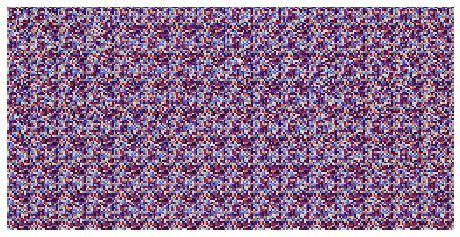

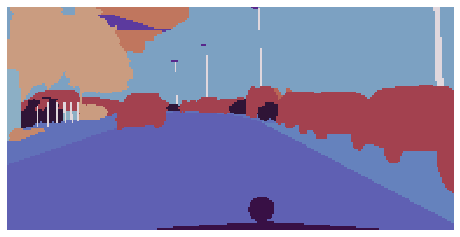

In [13]:
i = 1
image, target_mask = valid_dataset[i]
test_model(seq2seg, image, target_mask, save_pred=f'seq2seg_{i}.png', save_target=f'target_{i}.png')

In [14]:
def on_epoch_end(logs):
    if logs['epoch'] == 15:
        set_lr(seq2seg, 5e-5)
    if logs['epoch'] == 30:
        set_lr(seq2seg, 1e-5)

sec2seg_training_data = train_model(
    model=seq2seg,
    training_step_fn=training_step_fn, 
    trainloader=trainloader,
    validloader=validloader,
    print_every=10,
    epochs=45,
    on_epoch_end=on_epoch_end
)

with open('seq2seg_training_data_skip_weights.pickle', 'wb') as handle:
    pickle.dump(seq2seg_training_data, handle)

Epoch 0, iteration 10/123: running loss 0.1352, running acc 0.1484, batch loss: 0.1172, batch acc: 0.2595, running time per batch: 0.4751s (model) 0.0186s (loader)
Epoch 0, iteration 20/123: running loss 0.1148, running acc 0.2405, batch loss: 0.0989, batch acc: 0.3033, running time per batch: 0.2930s (model) 0.0152s (loader)
Epoch 0, iteration 30/123: running loss 0.0990, running acc 0.3102, batch loss: 0.0845, batch acc: 0.3758, running time per batch: 0.2294s (model) 0.0139s (loader)
Epoch 0, iteration 40/123: running loss 0.0921, running acc 0.3371, batch loss: 0.0880, batch acc: 0.3449, running time per batch: 0.2069s (model) 0.0134s (loader)
Epoch 0, iteration 50/123: running loss 0.0883, running acc 0.3522, batch loss: 0.0842, batch acc: 0.3643, running time per batch: 0.2000s (model) 0.0132s (loader)
Epoch 0, iteration 60/123: running loss 0.0866, running acc 0.3595, batch loss: 0.0853, batch acc: 0.3685, running time per batch: 0.1981s (model) 0.0137s (loader)
Epoch 0, iterati

Validation accuracy 0.3660, loss 0.0866
Epoch 4, iteration 10/123: running loss 0.0844, running acc 0.3724, batch loss: 0.0853, batch acc: 0.3561, running time per batch: 0.1962s (model) 0.0146s (loader)
Epoch 4, iteration 20/123: running loss 0.0852, running acc 0.3655, batch loss: 0.0861, batch acc: 0.3687, running time per batch: 0.1980s (model) 0.0154s (loader)
Epoch 4, iteration 30/123: running loss 0.0852, running acc 0.3645, batch loss: 0.0847, batch acc: 0.3463, running time per batch: 0.1968s (model) 0.0142s (loader)
Epoch 4, iteration 40/123: running loss 0.0860, running acc 0.3626, batch loss: 0.0884, batch acc: 0.3756, running time per batch: 0.1960s (model) 0.0137s (loader)
Epoch 4, iteration 50/123: running loss 0.0859, running acc 0.3648, batch loss: 0.0843, batch acc: 0.3884, running time per batch: 0.1965s (model) 0.0135s (loader)
Epoch 4, iteration 60/123: running loss 0.0862, running acc 0.3665, batch loss: 0.0944, batch acc: 0.3435, running time per batch: 0.1967s (

Epoch 7: training loss 0.0858, training accuracy 0.3619
Validation accuracy 0.3660, loss 0.0865
Epoch 8, iteration 10/123: running loss 0.0841, running acc 0.3708, batch loss: 0.0842, batch acc: 0.3511, running time per batch: 0.1959s (model) 0.0130s (loader)
Epoch 8, iteration 20/123: running loss 0.0849, running acc 0.3640, batch loss: 0.0867, batch acc: 0.3780, running time per batch: 0.1954s (model) 0.0131s (loader)
Epoch 8, iteration 30/123: running loss 0.0855, running acc 0.3654, batch loss: 0.0847, batch acc: 0.3728, running time per batch: 0.1953s (model) 0.0131s (loader)
Epoch 8, iteration 40/123: running loss 0.0859, running acc 0.3627, batch loss: 0.0881, batch acc: 0.3345, running time per batch: 0.1954s (model) 0.0131s (loader)
Epoch 8, iteration 50/123: running loss 0.0863, running acc 0.3645, batch loss: 0.0848, batch acc: 0.3813, running time per batch: 0.1969s (model) 0.0138s (loader)
Epoch 8, iteration 60/123: running loss 0.0856, running acc 0.3626, batch loss: 0.08

Epoch 11: training loss 0.0858, training accuracy 0.3620
Validation accuracy 0.3660, loss 0.0867
Epoch 12, iteration 10/123: running loss 0.0867, running acc 0.3469, batch loss: 0.0899, batch acc: 0.3337, running time per batch: 0.1969s (model) 0.0133s (loader)
Epoch 12, iteration 20/123: running loss 0.0857, running acc 0.3541, batch loss: 0.0847, batch acc: 0.3607, running time per batch: 0.1961s (model) 0.0134s (loader)
Epoch 12, iteration 30/123: running loss 0.0857, running acc 0.3611, batch loss: 0.0868, batch acc: 0.3607, running time per batch: 0.1958s (model) 0.0131s (loader)
Epoch 12, iteration 40/123: running loss 0.0859, running acc 0.3632, batch loss: 0.0838, batch acc: 0.3901, running time per batch: 0.1959s (model) 0.0130s (loader)
Epoch 12, iteration 50/123: running loss 0.0866, running acc 0.3617, batch loss: 0.0861, batch acc: 0.3592, running time per batch: 0.1982s (model) 0.0146s (loader)
Epoch 12, iteration 60/123: running loss 0.0863, running acc 0.3589, batch los

Epoch 15: training loss 0.0857, training accuracy 0.3620
Validation accuracy 0.3660, loss 0.0864
Epoch 16, iteration 10/123: running loss 0.0875, running acc 0.3601, batch loss: 0.0888, batch acc: 0.3477, running time per batch: 0.1988s (model) 0.0142s (loader)
Epoch 16, iteration 20/123: running loss 0.0868, running acc 0.3579, batch loss: 0.0931, batch acc: 0.3458, running time per batch: 0.1963s (model) 0.0134s (loader)
Epoch 16, iteration 30/123: running loss 0.0860, running acc 0.3624, batch loss: 0.0836, batch acc: 0.3653, running time per batch: 0.1954s (model) 0.0130s (loader)
Epoch 16, iteration 40/123: running loss 0.0858, running acc 0.3621, batch loss: 0.0805, batch acc: 0.3797, running time per batch: 0.1954s (model) 0.0128s (loader)
Epoch 16, iteration 50/123: running loss 0.0851, running acc 0.3676, batch loss: 0.0848, batch acc: 0.3807, running time per batch: 0.1967s (model) 0.0141s (loader)
Epoch 16, iteration 60/123: running loss 0.0859, running acc 0.3639, batch los

Epoch 19: training loss 0.0857, training accuracy 0.3618
Validation accuracy 0.3660, loss 0.0864
Epoch 20, iteration 10/123: running loss 0.0854, running acc 0.3684, batch loss: 0.0847, batch acc: 0.3616, running time per batch: 0.1956s (model) 0.0130s (loader)
Epoch 20, iteration 20/123: running loss 0.0850, running acc 0.3678, batch loss: 0.0855, batch acc: 0.3593, running time per batch: 0.1952s (model) 0.0130s (loader)
Epoch 20, iteration 30/123: running loss 0.0862, running acc 0.3619, batch loss: 0.0886, batch acc: 0.3517, running time per batch: 0.1952s (model) 0.0131s (loader)
Epoch 20, iteration 40/123: running loss 0.0855, running acc 0.3598, batch loss: 0.0862, batch acc: 0.3353, running time per batch: 0.1950s (model) 0.0128s (loader)
Epoch 20, iteration 50/123: running loss 0.0856, running acc 0.3602, batch loss: 0.0875, batch acc: 0.3430, running time per batch: 0.1972s (model) 0.0145s (loader)
Epoch 20, iteration 60/123: running loss 0.0872, running acc 0.3547, batch los

Epoch 23: training loss 0.0857, training accuracy 0.3619
Validation accuracy 0.3660, loss 0.0864
Epoch 24, iteration 10/123: running loss 0.0877, running acc 0.3421, batch loss: 0.0819, batch acc: 0.3666, running time per batch: 0.1964s (model) 0.0135s (loader)
Epoch 24, iteration 20/123: running loss 0.0865, running acc 0.3574, batch loss: 0.0820, batch acc: 0.3912, running time per batch: 0.1961s (model) 0.0139s (loader)
Epoch 24, iteration 30/123: running loss 0.0854, running acc 0.3636, batch loss: 0.0852, batch acc: 0.3454, running time per batch: 0.1961s (model) 0.0145s (loader)
Epoch 24, iteration 40/123: running loss 0.0853, running acc 0.3602, batch loss: 0.0839, batch acc: 0.3408, running time per batch: 0.1956s (model) 0.0138s (loader)
Epoch 24, iteration 50/123: running loss 0.0856, running acc 0.3569, batch loss: 0.0882, batch acc: 0.3352, running time per batch: 0.2029s (model) 0.0205s (loader)
Epoch 24, iteration 60/123: running loss 0.0854, running acc 0.3585, batch los

KeyboardInterrupt: 

In [51]:
with open('seq2seg_training_data.pickle', 'wb') as handle:
    pickle.dump(seq2seg_training_data, handle)

In [13]:
def evaluate_model(model, loader, training_step_fn):
    model.eval()
    
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0
        
    with torch.no_grad():
        for i, batch in enumerate(loader):
            num_samples, num_correct_samples, summed_loss = training_step_fn(model, batch)
            
            total_loss += float(summed_loss)
            total_correct += float(num_correct_samples)
            total_samples += float(num_samples)
            
    return total_loss/total_samples, total_correct/total_samples

def train_model(model,
    training_step_fn,
    trainloader,
    validloader=None,
    epochs=2,
    optimizer=None,
    print_every=1,
    on_epoch_end=lambda x: x,
    save_best_to=False,
    eval_every=None
    ):
    
    alpha = 0.9

    if optimizer is None:
        assert hasattr(model, 'optimizer'), 'Please provide an optimizer either as argument or by setting model.optimizer = ...'
        optimizer = model.optimizer
        
    total_steps = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    train_times = []

    for epoch in range(epochs):

        running_loss = 0.0
        running_accuracy = 0.0
        running_batch_time = 0.0
        running_loader_time = 0.0
        epoch_loss = 0.0
        epoch_correct = 0.0
        epoch_samples = 0
        
        model.train()
        
        t0 = time.time()
        for i, batch in enumerate(trainloader):
            
            if eval_every is not None and (i+1)%eval_every == 0:
                valid_loss, valid_accuracy = evaluate_model(model, validloader, training_step_fn)
                print(f'Validation accuracy {valid_accuracy:.4f}, loss {valid_loss:.4f}')
                val_losses.append(valid_loss)
                val_accuracies.append(valid_accuracy)
            
            if i == 0:
                running_loader_time = time.time() - t0
            else:
                running_loader_time = running_loader_time * alpha + (1-alpha) * (time.time() - t0)
            
            t0 = time.time()
            
            optimizer.zero_grad()
            
            num_samples, num_correct_samples, summed_loss = training_step_fn(model, batch)
            
            mean_loss = summed_loss/num_samples
            mean_loss.backward()
            optimizer.step()
            
            epoch_loss += summed_loss.item()
            epoch_correct += num_correct_samples.item()
            epoch_samples += num_samples
            
            accuracy = num_correct_samples/num_samples

            train_times.append(time.time() - t0)
            train_losses.append(mean_loss.item())
            train_accuracies.append(accuracy.item())

            if i == 0:
                running_loss = mean_loss.item()
                running_accuracy = accuracy.item()
                running_batch_time = time.time() - t0
            else:
                running_loss = running_loss * alpha + (1-alpha) * mean_loss.item()
                running_accuracy = running_accuracy * alpha + (1-alpha) * accuracy.item()
                running_batch_time = running_batch_time * alpha + (1-alpha) * (time.time() - t0)
                
            if i%print_every == print_every-1:
                print(f'Epoch {epoch}, iteration {i+1}/{len(trainloader)}: running loss {running_loss:.4f}, running acc {running_accuracy:.4f}, batch loss: {mean_loss.item():.4f}, batch acc: {accuracy.item():.4f}, running time per batch: {running_batch_time:.4f}s (model) {running_loader_time:.4f}s (loader)')
        
            t0 = time.time()
        
        train_loss = epoch_loss/epoch_samples
        train_accuracy = epoch_correct/epoch_samples
        print(f'Epoch {epoch}: training loss {train_loss:.4f}, training accuracy {train_accuracy:.4f}')
        
        if validloader is not None and eval_every is None:
            valid_loss, valid_accuracy = evaluate_model(model, validloader, training_step_fn)
            print(f'Validation accuracy {valid_accuracy:.4f}, loss {valid_loss:.4f}')
            val_losses.append(valid_loss)
            val_accuracies.append(valid_accuracy)

        on_epoch_end({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'valid_loss': None if validloader is None else valid_loss,
            'valid_accuracy': None if validloader is None else valid_accuracy
        })

    print('Finished Training')

    return train_times, train_losses, train_accuracies, val_losses, val_accuracies